# Modelo : Similitud del Coseno

In [1]:
# Carga de librerias 
import pandas as pd
import numpy as np
from PIL import Image
from wordcloud import WordCloud
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Leer los dataset par aluego consultarlos
ruta_steam_game = '..\\Datasets\\developer.parquet'
ruta_user_items = '..\\Datasets\\users_items.parquet'
ruta_user_reviews = '..\\Datasets\\user_review.parquet'

df_steam_game = pd.read_parquet(ruta_steam_game)
df_user_items = pd.read_parquet(ruta_user_items)
df_user_review = pd.read_parquet(ruta_user_reviews)

In [3]:
# Verifcamos los tipos de datos
df_steam_game.dtypes

year          object
item_id        int32
price        float64
developer     object
dtype: object

In [4]:
# Verifcamos los tipos de datos
df_user_items.dtypes

user_id              object
items_count           int64
item_name            object
playtime_forever    float64
playtime_2weeks     float64
item_id               int32
dtype: object

In [5]:
# Verifcamos los tipos de datos
print(df_user_review.shape)
df_user_review.dtypes

(10000, 5)


user_id               object
item_id                int32
recommend               bool
review                object
sentiment_analysis     int64
dtype: object

In [6]:
# Necesitamos cambiar el tipo de datos a item_id en reviews
item_int = df_user_review["item_id"].astype(str).astype(int)
print(item_int.dtypes)

int32


In [7]:
# Observemos los datos 
df_user_review.head(3)

,user_id,item_id,recommend,review,sentiment_analysis
0,InspyrBOI,550,True,LUV IT,1
1,76561198052193514,252490,True,I was absolutely obsessed with this game back ...,2
2,dannysfatass,304930,True,cs:go skins,1


In [8]:
# Para el modelo reemplazamos los alores de True y Falso por sus valores 1 y 0 respectivamente
reemplazar_valores = {True: 1, False: 0}
df_user_review.replace(reemplazar_valores,inplace=True)

In [9]:
# Extraemos una muestra de reviews
df_reviews = df_user_review.sample(n=1000, random_state=7)
print(df_reviews.shape)

(1000, 5)


In [10]:
# Observemos los datos 
df_reviews.head(2)

,user_id,item_id,recommend,review,sentiment_analysis
1977,76561198029997863,346010,1,i have beaten the first world section and i s...,2
3880,epagames,440,1,这是我见过的最棒的游戏，它独特创新的卡通风格以及多种有趣的模式和玩法很容易让人上瘾，当然，这...,1


In [11]:
# Creamos un dataframe con las columnas item_id y item_name
items_juegos = df_user_items[["item_id","item_name"]]
items_juegos.drop_duplicates(inplace=True)
items_juegos.duplicated().sum()

0

In [12]:
# Observemos el nuevo dataframe
items_juegos.head(2)

,item_id,item_name
0,258010,Ring Runner: Flight of the Sages
1,224900,Iron Sky Invasion


In [13]:
# Convertimos el dataframe item_juegos en una matriz de dimension n x 2 (n filas por 2 columnas)
matriz_numpy = items_juegos.to_numpy()

In [14]:
# Creamos una funcion para verificar el nombre de un juego dado el item
def buscar_nombre_item(item_id):
    #item_name = items_juegos[items_juegos["item_id"] == item_id].iloc[0, 1]
    for ind,fila in enumerate(matriz_numpy):
        if pd.to_numeric(fila[0]) == item_id:
            item_name = fila[1]
            break
    return item_name

In [15]:
# Verificacion de la funcion
buscar_nombre_item(550)

'Left 4 Dead 2'

In [16]:
# Cambiamos el tipo de datos para item_id en df_user_review
df_user_review[["item_id"]] = df_user_review[["item_id"]].astype(int)
df_user_review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   user_id             10000 non-null  object
 1   item_id             10000 non-null  int32 
 2   recommend           10000 non-null  int64 
 3   review              10000 non-null  object
 4   sentiment_analysis  10000 non-null  int64 
dtypes: int32(1), int64(2), object(2)
memory usage: 351.7+ KB


In [17]:
# Ahora hacemos un merge con los 2 dataframe
df1 = pd.merge(df_user_review, items_juegos, how='left', on=['item_id'], indicator=True)
df1.head(2)

,user_id,item_id,recommend,review,sentiment_analysis,item_name,_merge
0,InspyrBOI,550,1,LUV IT,1,Left 4 Dead 2,both
1,76561198052193514,252490,1,I was absolutely obsessed with this game back ...,2,Rust,both


In [18]:
# Borramos valores nulos
df1.dropna(inplace=True)

In [19]:
# Verificamos cantidad de valores nulos
df1.isnull().sum()

user_id               0
item_id               0
recommend             0
review                0
sentiment_analysis    0
item_name             0
_merge                0
dtype: int64

In [20]:
# Eliminamos la columna _merge
df1.drop(["_merge"],axis=1,inplace=True)

In [21]:
# Creamos un nuevo dataframe df_sentiment_analysis a partir de df1
df_sentiment_analysis = df1
df_sentiment_analysis.head(2)

,user_id,item_id,recommend,review,sentiment_analysis,item_name
0,InspyrBOI,550,1,LUV IT,1,Left 4 Dead 2
1,76561198052193514,252490,1,I was absolutely obsessed with this game back ...,2,Rust


In [22]:
# Extraemos una muestra de registro
df_sentiment_analysis = df_sentiment_analysis.sample(n=1000, random_state=7)
df_sentiment_analysis.shape

(1000, 6)

In [23]:
# Crear un archivo con formato parquet
ruta = '..\\Datasets\\sentiment_analysis.parquet'
df_sentiment_analysis.to_parquet(ruta, compression='snappy', index=False)

In [24]:
# Crear un archivo con formato parquet
ruta = '..\\Datasets\\sentiment_analysis.parquet'
df_sentiment_analysis = pd.read_parquet(ruta)

In [25]:
# Verificamos los valores en la columna reviews
df_sentiment_analysis["review"].head(5)

0    An incredible Rpg, Sandbox and action game... ...
1    One of the single greatest Music based games e...
2    -fun to play with friends-fun to play when bor...
3                                             its good
4                                     Best game ever !
Name: review, dtype: object

In [26]:
# En el proyecto no utilice stop_words
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(df_sentiment_analysis["review"])

In [27]:
# Vamos agregar las variables numéricas a la matriz de características
feactures =  np.column_stack([tfidf_matrix.toarray(), df_sentiment_analysis["recommend"], df_sentiment_analysis["sentiment_analysis"]])

In [28]:
# Reindexamos el DataFrame
df_sentiment_analysis = df_sentiment_analysis.reset_index(drop=True)

In [29]:
# Calculamos la matriz de similitud de coseno
similarity_matrix = cosine_similarity(feactures)

### Algunas pruebas de recomendación

In [30]:
# El siguiente codigo permite realizar las similitudes dado el nombre de un juego
nombre_del_producto = "Left 4 Dead 2" 
producto = df_sentiment_analysis[df_sentiment_analysis['item_name'] == nombre_del_producto]
if not producto.empty:
    product_index = producto.index[0]
    product_similarities = similarity_matrix[product_index]
    most_similar_products_indices = np.argsort(-product_similarities)
    most_similar_products = df_sentiment_analysis.loc[most_similar_products_indices, 'item_name']
    print("Los productos más similares al producto", nombre_del_producto, "son:")
    print(most_similar_products)
else:
    print("Producto no encontrado")

Los productos más similares al producto Left 4 Dead 2 son:
44                            Left 4 Dead 2
867               Five Nights at Freddy's 2
980                   Day of Defeat: Source
473                          Counter-Strike
102                           Town of Salem
                       ...                 
573                                PAYDAY 2
49     Real Horror Stories Ultimate Edition
337                      H1Z1: Just Survive
29                       Fallout: New Vegas
301                              Watch_Dogs
Name: item_name, Length: 1000, dtype: object


In [33]:
# El id para el juego para el que quieres hacer recomendaciones
id_juego = 11610  
producto = df_sentiment_analysis[df_sentiment_analysis['item_id'] == id_juego]
if not producto.empty:
    product_index = producto.index[0]
    product_similarities = similarity_matrix[product_index]
    most_similar_products_indices = np.argsort(-product_similarities)
    most_similar_products = df_sentiment_analysis.loc[most_similar_products_indices, 'item_name']
    print("Los productos más similares al producto", nombre_del_producto, "son:")
    print(most_similar_products)
else:
    print("Producto no encontrado")

Los productos más similares al producto World of Guns: Gun Disassembly son:
352                             Dragon Nest
312                   Sniper Art of Victory
884                             Garry's Mod
255                     Stronghold Kingdoms
256                              Radiator 2
                       ...                 
750                 Blacklight: Retribution
140              Chivalry: Medieval Warfare
403                             The Culling
54     Real Horror Stories Ultimate Edition
307                     Drift Streets Japan
Name: item_name, Length: 1000, dtype: object


In [34]:
type(most_similar_products)

pandas.core.series.Series

In [35]:
# Dar formato a la informacion
diccionario = {"Los productos más similares" : list()}
similares = most_similar_products[:5]
diccionario["Los productos más similares"] = [similar for similar in similares]
diccionario


{'Los productos más similares': ['Dragon Nest',
  'Sniper Art of Victory',
  "Garry's Mod",
  'Stronghold Kingdoms',
  'Radiator 2']}

In [97]:
# Crear una funcion para manejar el  tono, saturacion e iluminacion
import random


def grey_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(40, 0%%, %d%%)" % random.randint(10, 60)

In [98]:
# Convertir la imagen en un arreglo
mask = np.array(Image.open(r"../img/cloud.png"))
mask[mask == 1] = 255



In [99]:
# Creamos una cadena de texto a partir de la columna item_name
cadena_de_texto = " ".join(df_sentiment_analysis["item_name"])

In [104]:
# Devuelve el texto en una imagen de nube de palabras
wordcloud = WordCloud(background_color = "white", max_words = 1000, stopwords='english', mask = mask,random_state=7, margin=10).generate(cadena_de_texto)

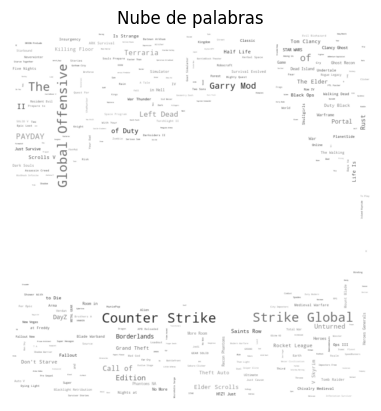

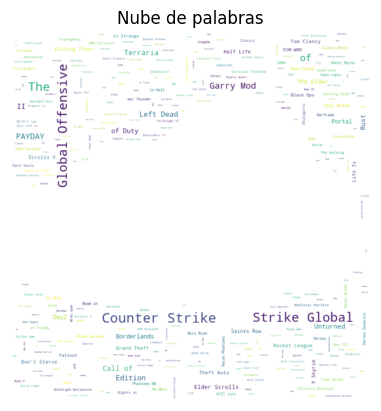

In [105]:
# Generar y gaurdar la imagen nube de palabras
default_colors = wordcloud.to_array()
plt.title("Nube de palabras")
plt.imshow(wordcloud.recolor(color_func=grey_color_func, random_state=3),interpolation="bilinear")
wordcloud.to_file(r"../img/nube_palabras.png")
plt.axis("off")
plt.figure()
plt.title("Nube de palabras")
plt.imshow(default_colors, interpolation="bilinear")
wordcloud.to_file(r"../img/nube_palabras2.png")
plt.axis("off")
plt.show()

In [54]:
#plt.imshow(wordcloud)
#plt.axis("off")
#plt.show();